# Music Genre Classification

> Damian Valle (damianvs@kth.se)

In this report we tackle multiple MIR problems. We being by exploring our dataset and examining it's flaws to be able to build better models and better interpret their results. We build a simple recommender system and also use it to find replicas in the dataset. We then try different classifier architectures and face different problems, mainly overfitting. We finally discuss our results and how could this project be improved.

In [ ]:
import pandas as pd
import os
import sys
import numpy as np
from numpy import unique
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import librosa
import librosa.display
import glob
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/path/to/your/data/folder')

Mounted at /content/drive


In [ ]:
# GPU enable
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#Dataset exploration

Apart from convenience reasons, we choose to use the extracted features from the dataset in order to compare the results with the results from models using raw spectrograms as input. Instead of learning tabula rasa and letting the algorithm figure everything out by itself, we can use smaller models by including musical knowledge aware features such as tempo, chroma or MFCC. Given that we want to classify western music made by humans; tempo is a revelant feature, chroma features relate to the twelve pitch classes yielding a powerful mid level audio representation, MFCCs maps the power onto a mel-scale which is a perceptual scale done by human experiments. It could be argued that by actively choosing these features we are biasing the model but even the label can be biased since music genre doesn't have an absolute ground truth and this dataset contains single labels. It is important to acknowledge the limitations of our experiments and the integrity of our dataset which we will discuss later on.

In [ ]:
df=pd.read_csv("features_30_sec.csv")
df

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0    blues.00000.wav  661794          0.350088  ...     1.221291   46.936035  blues
1    blues.00001.wav  661794          0.340914  ...     0.531217   45.786282  blues
2    blues.00002.wav  661794          0.363637  ...    -2.231258   30.573025  blues
3    blues.00003.wav  661794          0.404785  ...    -3.407448   31.949339  blues
4    blues.00004.wav  661794          0.308526  ...   -11.703234   55.195160  blues
..               ...     ...               ...  ...          ...         ...    ...
995   rock.00095.wav  661794          0.352063  ...    -1.193787   49.950665   rock
996   rock.00096.wav  661794          0.398687  ...    -2.795338   31.773624   rock
997   rock.00097.wav  661794          0.432142  ...    -2.106337   29.865515   rock
998   rock.00098.wav  661794          0.362485  ...    -3.590644   41.299088   rock
999   rock.00099.wav  661794          0.358401  ...     1.155239   49.662510   rock

[1000 rows x 60 columns]

Let's take a look at some of the statistical properties of one of the features.

In [ ]:
df["spectral_centroid_mean"].describe()

count    1000.000000
mean     2201.780898
std       715.960600
min       570.040355
25%      1627.697311
50%      2209.263090
75%      2691.294667
max      4435.243901
Name: spectral_centroid_mean, dtype: float64

In [ ]:
# Delete non useful data columns and separate target from the features.

x = df.drop("filename", axis=1)
x = x.drop("length", axis=1)
x = x.drop("label", axis=1)
x = x.to_numpy()
x = StandardScaler().fit_transform(x)

y = df.loc[:,['label']]

print("Labels: ")
for label in unique(y):
  print("\t" + label)

Labels: 
	blues
	classical
	country
	disco
	hiphop
	jazz
	metal
	pop
	reggae
	rock


## PCA

Now we try to reduce the high dimensionality of the dataset by projecting samples onto 2D to be able to plot it and get any meaningful results.

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['label']]], axis = 1)

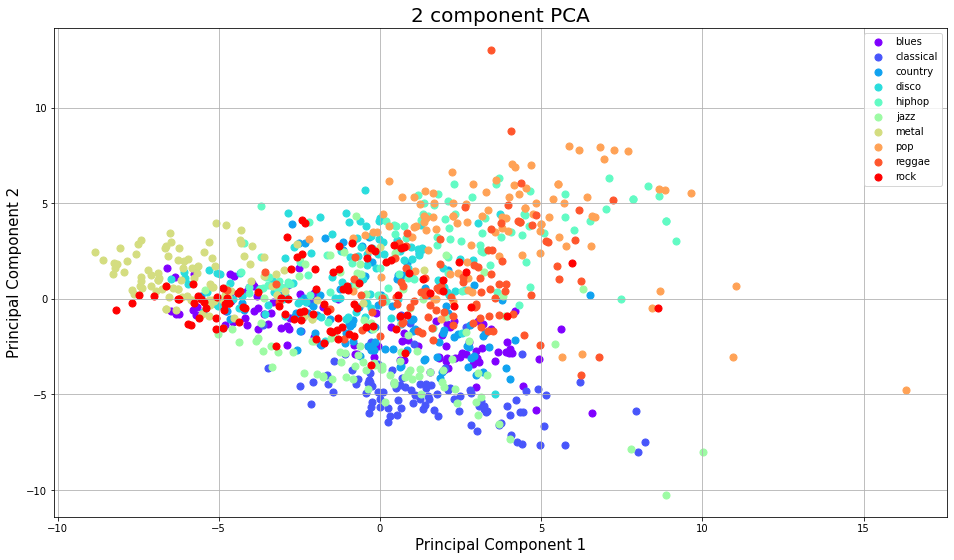

In [ ]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = unique(y)
colors = cm.rainbow(np.linspace(0, 1, len(targets)))
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , color = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
print("PCA explained variance per component: {}".format(pca.explained_variance_ratio_))
print("Total PCA explained variance: {:.2f}".format(pca.explained_variance_ratio_.sum()))

PCA explained variance per component: [0.23949564 0.16929248]
Total PCA explained variance: 0.41


From the plot we see that metal can be easily distinguished from classical music and pop but it's genres like rock that mix with almost every other genre that make the blob separation impossible. It can be seen that not even half of the variance of the samples can be retained by only 2 PCA components, thus the plot doesn't show clearly separated blobs. Taking this into consideration, it is still reasonable to try performing a classification task.

We will later check if the confusion matrix of our classification models yields results that are according to this representation.

# Similarity and recomendation

One interesting integration of the extracted features is a very basic recommender system. Before starting with the classification task we build such system to shed some light on the nature of the dataset.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import IPython.display as ipd
from IPython.display import Image

First we import the dataset, separate the labels, remove useless columns and standarize the data.

In [ ]:
x = df.drop("filename", axis=1)
x = x.drop("length", axis=1)
x = x.drop("label", axis=1)
x = x.to_numpy()
x = StandardScaler().fit_transform(x)

labels = df[['filename']]

The similarity measure we use here is the **cosine similarity** which is computed as the normalized dot product of two vectors. We store the output in a pandas dataframe with a 1000x1000 matrix where the diagonal is made of ones because each song is identical to itself. The matrix is also symmetrical from the diagonal because the dot product is conmutative. The higher the similarity value the more alike are those songs.

In [ ]:
similarity = cosine_similarity(x)
similarity_df = pd.DataFrame(similarity)
similarity_df.rename(columns=df["filename"], index=df["filename"], inplace=True)

similarity_df

blues.00000.wav  ...  rock.00099.wav
blues.00000.wav         1.000000  ...        0.304098
blues.00001.wav         0.049231  ...        0.311723
blues.00002.wav         0.589618  ...        0.321069
blues.00003.wav         0.284862  ...        0.183210
blues.00004.wav         0.025561  ...        0.061785
...                          ...  ...             ...
rock.00095.wav          0.610942  ...        0.522483
rock.00096.wav          0.640835  ...        0.472331
rock.00097.wav          0.496294  ...        0.415173
rock.00098.wav          0.284958  ...        0.589041
rock.00099.wav          0.304098  ...        1.000000

[1000 rows x 1000 columns]

We now define a function that, given a song name, ranks the highest and lowest similarity matches and displays them.

In [ ]:
def rank_similarity(name):
    rank = similarity_df[name].sort_values(ascending = False)
    rank = rank.drop(name)
    
    print("Top matches for {}".format(name))
    print(rank.head(5))

    print("\n\nBottom matches for {}".format(name))
    print(rank.tail(5))

In [ ]:
rank_similarity('country.00097.wav')

Top matches for country.00097.wav
country.00094.wav    0.709807
country.00098.wav    0.647876
country.00083.wav    0.626627
blues.00085.wav      0.604220
blues.00090.wav      0.590393
Name: country.00097.wav, dtype: float64


Bottom matches for country.00097.wav
rock.00040.wav    -0.652676
jazz.00083.wav    -0.654157
rock.00057.wav    -0.664636
disco.00013.wav   -0.693642
disco.00031.wav   -0.699943
Name: country.00097.wav, dtype: float64


In [ ]:
songname = "country.00097.wav"
path = "genres_original/" + songname.split(".")[0] + "/" + songname
ipd.Audio(path)

In [ ]:
songname = "blues.00085.wav"
path = "genres_original/" + songname.split(".")[0] + "/" + songname
ipd.Audio(path)

In [ ]:
songname = "disco.00013.wav"
path = "genres_original/" + songname.split(".")[0] + "/" + songname
ipd.Audio(path)

As shown in http://www.eecs.qmul.ac.uk/~sturm/research/GTZANtable2/index.html, the dataset has some exact matches.

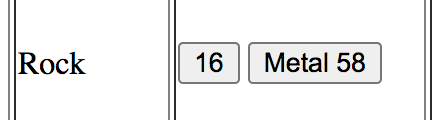

In [ ]:
Image("/content/rock.png")

In [ ]:
rank_similarity("rock.00016.wav")

Top matches for rock.00016.wav
metal.00058.wav    1.000000
rock.00017.wav     0.949540
metal.00028.wav    0.934571
metal.00059.wav    0.913482
rock.00087.wav     0.912965
Name: rock.00016.wav, dtype: float64


Bottom matches for rock.00016.wav
reggae.00058.wav   -0.669030
reggae.00093.wav   -0.679522
rock.00063.wav     -0.689175
hiphop.00040.wav   -0.716161
pop.00049.wav      -0.723074
Name: rock.00016.wav, dtype: float64


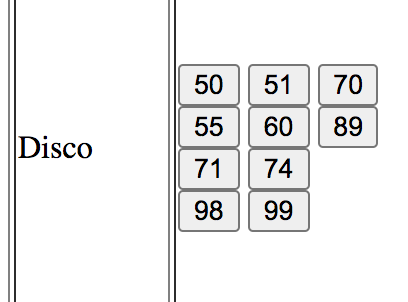

In [ ]:
Image("/content/disco.png")

In [ ]:
rank_similarity("disco.00050.wav")

Top matches for disco.00050.wav
disco.00051.wav    0.970690
disco.00070.wav    0.968893
rock.00073.wav     0.921346
metal.00046.wav    0.917379
metal.00049.wav    0.917241
Name: disco.00050.wav, dtype: float64


Bottom matches for disco.00050.wav
pop.00049.wav       -0.625048
reggae.00058.wav    -0.652923
reggae.00083.wav    -0.664976
pop.00041.wav       -0.674819
country.00011.wav   -0.681969
Name: disco.00050.wav, dtype: float64


Matches will happen whenever the cosine similarity is 1. We then try to find those cases and we find some of the matches reported in the 
aforementioned link. 
(I didn't have enough time to figure out why not all the exact matches were found, lowering the threshold yields finding more matches)

In [ ]:
i, c = np.where(similarity_df > 0.98)

In [ ]:
shown = []
for j in range(len(i)):
  if ((similarity_df.index[i][j] != similarity_df.columns[c][j])):
    if(not similarity_df.index[i][j] in shown):
      print((similarity_df.index[i][j], similarity_df.columns[c][j]))
    shown.append(similarity_df.index[c][j])

('disco.00051.wav', 'disco.00070.wav')
('disco.00098.wav', 'disco.00099.wav')
('hiphop.00039.wav', 'hiphop.00045.wav')
('hiphop.00076.wav', 'hiphop.00078.wav')
('jazz.00033.wav', 'jazz.00051.wav')
('jazz.00035.wav', 'jazz.00055.wav')
('jazz.00039.wav', 'jazz.00065.wav')
('jazz.00040.wav', 'jazz.00067.wav')
('jazz.00044.wav', 'jazz.00070.wav')
('jazz.00046.wav', 'jazz.00072.wav')
('metal.00017.wav', 'metal.00019.wav')
('metal.00034.wav', 'metal.00094.wav')
('metal.00040.wav', 'metal.00061.wav')
('metal.00041.wav', 'metal.00062.wav')
('metal.00042.wav', 'metal.00063.wav')
('metal.00043.wav', 'metal.00064.wav')
('metal.00044.wav', 'metal.00065.wav')
('metal.00045.wav', 'metal.00066.wav')
('metal.00048.wav', 'metal.00049.wav')
('metal.00050.wav', 'metal.00053.wav')
('metal.00058.wav', 'rock.00016.wav')
('pop.00015.wav', 'pop.00022.wav')
('pop.00030.wav', 'pop.00031.wav')
('pop.00045.wav', 'pop.00046.wav')
('pop.00047.wav', 'pop.00080.wav')
('pop.00052.wav', 'pop.00057.wav')
('pop.00054.wav

## Dataset conclusions
From the analysis performed here and reading [[2]](https://arxiv.org/abs/1306.1461) "The GTZAN dataset: Its contents, its faults, their effects on evaluation, and its future use", we conclude the following:

* Given that there are exact replicas, the same song may find it's way into the train and test sets simultaneously. Some classification methods might be more favoured than others e.g. a KNN finding a zero distance sample to one of the training samples.

* On the other hand, if both samples lay on the test set, one wrong prediction yields multiple wrong predictions biasing the figure of merit.

To combat these flaws we use a [fault fold partition](https://code.soundsoftware.ac.uk/projects/scatter-analysis/repository/show/mca/dataset/folds) that takes this into account. It could be argued that the GTZAN dataset is not suitable for our experiments but we will use it because now we know about it's flaws and limitations and we can better interpret the results.

We still have the open question about MGR as a feasible task or if we are not just training a horse[1]. That question lies outside of the scope of this project so from now on we will naively work with GTZAN to implement our MIR models.

In [ ]:
train = open('train_fault.txt', 'r').read().split('\n')[:-1]
valid = open('valid_fault.txt', 'r').read().split('\n')[:-1]
test = open('test_fault.txt', 'r').read().split('\n')[:-1]

print("Train size:\t{}\nValid size:\t{}\nTest size:\t{}".format(len(train), len(valid), len(test)))

Train size:	443
Valid size:	197
Test size:	290


## Feed Forward Neural Network
As a first naive approach, we build a simple FFNN using the extracted features as input. We design the topology to have two hidden layers of 128 and 64 neurons and an output layer of the number of different genres.

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []

for sample in train:
  filename = sample.split("/")[1]

  row = df[df['filename'].str.match(filename)]
  row = row.drop("length", axis=1)
  row = row.drop("filename", axis=1)
  row = row.drop("label", axis=1)
  row = row.to_numpy()

  X_train.append(row)
  y_train.append(filename.split(".")[0])

for sample in test:
  filename = sample.split("/")[1]

  row = df[df['filename'].str.match(filename)]
  row = row.drop("length", axis=1)
  row = row.drop("filename", axis=1)
  row = row.drop("label", axis=1)
  row = row.to_numpy()

  X_test.append(row)
  y_test.append(filename.split(".")[0])

In [ ]:
X_train = np.squeeze(np.asarray(X_train))
X_test = np.squeeze(np.asarray(X_test))

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy', # Sparse because labels are provided as integers insted of one-hot.
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=128,
                    verbose=0)

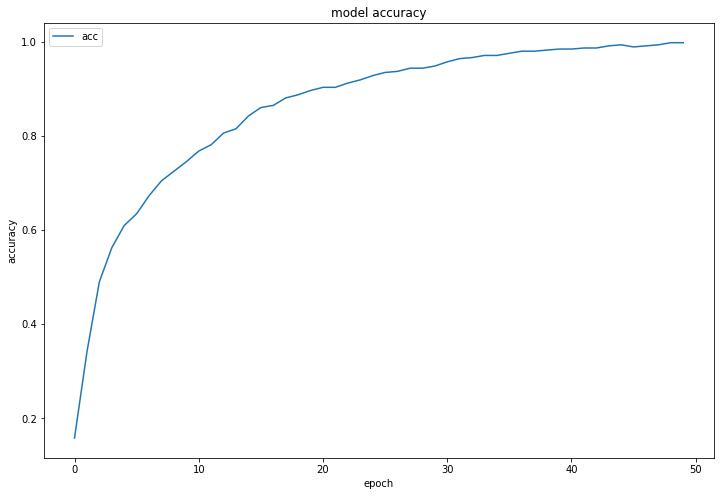

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc'])
plt.show()

In [ ]:
score = model.evaluate(x=X_test, y=y_test, verbose=0)
print("Test accuracy:\t{:.2f}".format(score[1]))

Test accuracy:	0.56


We have a 100% training accuracy and 56% test accuracy, this is a clear overfitting indicator. Despite trying decreasing the model complexity and various regularization methods such as dropout I couldn't combat overfitting, this is probably due to the low amount of training samples.

Despite that fact, our network managed to get more than half of the genres right which is way better than random chance. We are not sure exactly what, but it learned something and that something is not replicas since we used the corrected folds.

## Convolutional Neural Network
We now try a much higher dimensional approach. Instead of working with the extracted features we use the raw information of each song by extracting its spectrogram. As the spectrogram is a bidimensional representation we can use image models to perform the classification task, in this case a CNN. This makes sense because CNNs have been deeply studied and we can even repurpose pre-trained models as feature extractors and train simple FFNN classifiers on top of them.

On the other hand, as discussed in [this article](https://towardsdatascience.com/whats-wrong-with-spectrograms-and-cnns-for-audio-processing-311377d7ccd#:~:text=In%20spectrograms%2C%20the%20two%20dimensions,and%20the%20other%20being%20time.&text=Therefore%2C%20the%20spatial%20invariance%20that,for%20this%20form%20of%20data.) and [this paper](https://arxiv.org/abs/1706.09559), CNNs might not be well fit for spectrogram data because of the following reasons:
* Spectrogram axes do not carry the same meaning and convolution kernels don't take that into account.
* Kernels assume local pixels belong to the same object but spectral properties might be non-local.
* Kernels have the spatial invariance property while absolute position matters in spectral representation, e.g. height in frequency can help distinguish between male and female voice.

With these limitations in mind, we proceed to train our models and evaluate their performance.

In [ ]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv1D, Conv2D, Flatten, BatchNormalization, ZeroPadding2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras import models
from keras import layers
from sklearn.utils import shuffle

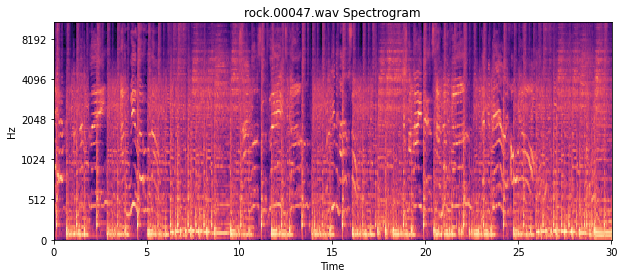

In [ ]:
y, sr = librosa.load("genres_original/rock/rock.00047.wav")
ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(ps, ref=np.max), y_axis='mel', x_axis='time')
plt.title("rock.00047.wav Spectrogram")
plt.show()

In [ ]:
# Progress bar utility to keep track of the dataset generation.
def progressBar(text, value, endvalue, bar_length=40):

        percent = float(value) / endvalue
        arrow = '-' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))

        sys.stdout.write("\r{2}: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100)), text))
        sys.stdout.flush()

In [ ]:
X_train = []
X_val = []
X_test = []

y_train = []
y_val = []
y_test = []

for i, filename in enumerate(train):
  path = "genres_original/" + filename
  out, sr = librosa.load(path)
  db_melspec = librosa.power_to_db(librosa.feature.melspectrogram(y=out, sr=sr, n_mels=128), ref=np.max)

  X_train.append(db_melspec)
  y_train.append(filename.split(".")[0])
  progressBar("Train", i, len(train))

for i, filename in enumerate(valid):
  path = "genres_original/" + filename
  out, sr = librosa.load(path)
  db_melspec = librosa.power_to_db(librosa.feature.melspectrogram(y=out, sr=sr, n_mels=128), ref=np.max)

  X_val.append(db_melspec)
  y_val.append(filename.split(".")[0])
  progressBar("Valid", i, len(valid))

for i, filename in enumerate(test):
  path = "genres_original/" + filename
  out, sr = librosa.load(path)
  db_melspec = librosa.power_to_db(librosa.feature.melspectrogram(y=out, sr=sr, n_mels=128), ref=np.max)

  X_test.append(db_melspec)
  y_test.append(filename.split(".")[0])
  progressBar("Test", i, len(test))

Test: [--------------------------------------->] 100%

In [ ]:
X_train = np.array([x[:,:1290].reshape( (128, 1290, 1) ) for x in X_train])
X_val = np.array([x[:,:1290].reshape( (128, 1290, 1) ) for x in X_val])
X_test = np.array([x[:,:1290].reshape( (128, 1290, 1) ) for x in X_test])

encoder = LabelEncoder()
y_train = np.array(keras.utils.to_categorical(encoder.fit_transform(y_train), 10))
y_val = np.array(keras.utils.to_categorical(encoder.transform(y_val), 10))
y_test = np.array(keras.utils.to_categorical(encoder.transform(y_test), 10))

In [ ]:
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
keras.backend.clear_session()

model = Sequential()
input_shape=(128, 1290, 1)

model.add(Conv2D(16, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(32, (5, 5), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dropout(rate=0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 1286, 16)     416       
_________________________________________________________________
activation (Activation)      (None, 124, 1286, 16)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 643, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 643, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 643, 32)       12832     
_________________________________________________________________
activation_1 (Activation)    (None, 62, 643, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 321, 32)       0

In [ ]:
epochs = 150
batch_size = 128

adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs=epochs)

Epoch 1/150
4/4 [==============================] - 1s 201ms/step - loss: 87.0669 - accuracy: 0.1151 - val_loss: 2.4957 - val_accuracy: 0.1117
Epoch 2/150
4/4 [==============================] - 1s 142ms/step - loss: 2.9561 - accuracy: 0.1106 - val_loss: 2.3002 - val_accuracy: 0.1168
Epoch 3/150
4/4 [==============================] - 1s 141ms/step - loss: 2.3160 - accuracy: 0.1309 - val_loss: 2.3030 - val_accuracy: 0.1472
Epoch 4/150
4/4 [==============================] - 1s 141ms/step - loss: 2.3074 - accuracy: 0.1084 - val_loss: 2.3026 - val_accuracy: 0.1269
Epoch 5/150
4/4 [==============================] - 1s 140ms/step - loss: 2.3060 - accuracy: 0.1038 - val_loss: 2.3006 - val_accuracy: 0.1371
Epoch 6/150
4/4 [==============================] - 1s 142ms/step - loss: 2.2957 - accuracy: 0.1129 - val_loss: 2.3027 - val_accuracy: 0.1675
Epoch 7/150
4/4 [==============================] - 1s 142ms/step - loss: 2.2979 - accuracy: 0.0880 - val_loss: 2.3002 - val_accuracy: 0.1472
Epoch 8/150


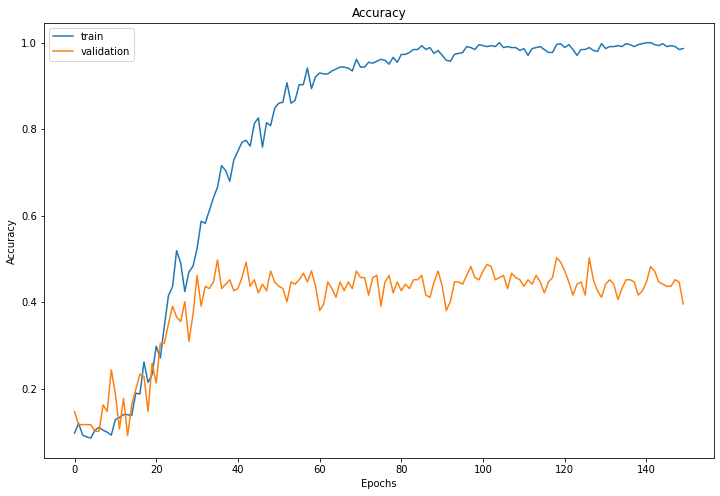

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(x=X_test, y=y_test)
print("Test accuracy:\t{:.2f}".format(score[1]))

10/10 [==============================] - 0s 14ms/step - loss: 3.0564 - accuracy: 0.4759
Test accuracy:	0.48


We see that the training accuracy reaches almost 100% while validation and test accuracies stay a bit below 50%. This is a clear case of overfitting that we will try to mitigate by:
* Decreasing model complexity.
* Adding more dropout
* Trying regularization

In [ ]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))

Normalized confusion matrix


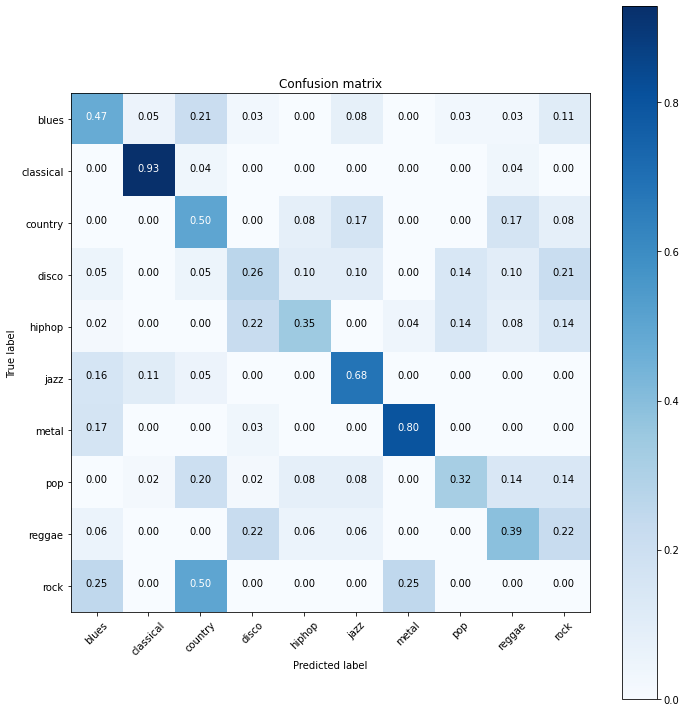

In [ ]:
keys = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

From the confusion matrix and also looking at the 2D PCA projection in the dataset exploration part we can extract some conclusions. For example classical and metal labels are mostly correctly predicted as they lie on the outer parts of the projection where the classification is easier to make. As opposed to that, the network has decided never to classify a sample as rock because it lies on the middle of the projection and instead classifies half of the true rock samples as country which also lies in the center. This is proof that the network is just trying whatever is necessary just to bring the loss down even when it doesn't make much musical sense.

In [ ]:
keras.backend.clear_session()

model = Sequential()
input_shape=(128, 1290, 1)

model.add(Conv2D(16, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(32, (5, 5), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(512, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dropout(rate=0.2))

model.add(Dense(64, kernel_regularizer=l2(0.04), bias_regularizer=l2(0.04)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(64, kernel_regularizer=l2(0.04), bias_regularizer=l2(0.04)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 1286, 16)     416       
_________________________________________________________________
activation (Activation)      (None, 124, 1286, 16)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 643, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 643, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 643, 32)       12832     
_________________________________________________________________
activation_1 (Activation)    (None, 62, 643, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 321, 32)       0

In [ ]:
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

epochs = 250
batch_size = 128

adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size = batch_size, epochs=epochs, callbacks=[reduceLROnPlat])

Epoch 1/250
4/4 [==============================] - 1s 164ms/step - loss: 2.8770 - accuracy: 0.1129 - val_loss: 2.7234 - val_accuracy: 0.1015
Epoch 2/250
4/4 [==============================] - 0s 122ms/step - loss: 2.6965 - accuracy: 0.0858 - val_loss: 2.6201 - val_accuracy: 0.1015
Epoch 3/250
4/4 [==============================] - 0s 123ms/step - loss: 2.6020 - accuracy: 0.1106 - val_loss: 2.5747 - val_accuracy: 0.1015
Epoch 4/250
4/4 [==============================] - 0s 123ms/step - loss: 2.5639 - accuracy: 0.1084 - val_loss: 2.5444 - val_accuracy: 0.1015
Epoch 5/250
4/4 [==============================] - 0s 121ms/step - loss: 2.5328 - accuracy: 0.1129 - val_loss: 2.5191 - val_accuracy: 0.1015
Epoch 6/250
4/4 [==============================] - 0s 124ms/step - loss: 2.4952 - accuracy: 0.1038 - val_loss: 2.4330 - val_accuracy: 0.1015
Epoch 7/250
4/4 [==============================] - 0s 121ms/step - loss: 2.4750 - accuracy: 0.1174 - val_loss: 2.4793 - val_accuracy: 0.1929
Epoch 8/250
4

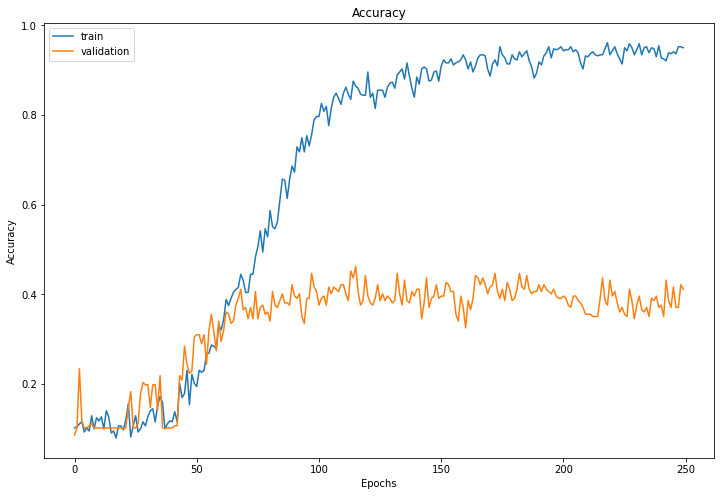

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(x=X_test, y=y_test)
print("Test accuracy:\t{:.2f}".format(score[1]))

10/10 [==============================] - 0s 15ms/step - loss: 3.7375 - accuracy: 0.5000
Test accuracy:	0.50


Our test accuracy has increased just a bit, probably due to the learning rate scheduler. Even though we tried techniques to reduce overfitting like dropout, L2 regularization and reducing the model's complexity we couldn't reduce overfitting. That fact leads to think that the issue is lack of training data for which data augmentation could be used.

# VGG16: Transfer Learning
Now that we have built our own CNN architecture, we want to compare it's performance with a prebuilt and pretrained model. We choose the VGG16 model as it's not one of the biggest and it comes with a set of pretrained weights from ImageNet. ImageNet is a natural images dataset while our dataset consists of synthetic images (spectrograms), nevertheless the feature extractors can still extract meaningful information as stated in [this paper](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11129/Hinterstoisser_On_Pre-Trained_Image_Features_and_Synthetic_Images_for_Deep_Learning_ECCVW_2018_paper.pdf).

We use only the convolutional parts of the VGG16 and use the extracted features as input to a FFNN classifier. When training the model we freeze all layers except for the classifier. We also have to extend the spectrograms by duplication up to three channels to match the VGG16 input shape.

In [ ]:
from tensorflow.keras.applications import VGG16
import tensorflow as tf

In [ ]:
def VGG_reshape(X):
  X_reshaped = np.zeros((X.shape[0], 128, 1290, 3))
  X_reshaped[:,:,:,0] = X.squeeze()
  X_reshaped[:,:,:,1] = X.squeeze()
  X_reshaped[:,:,:,2] = X.squeeze()

  return X_reshaped

In [ ]:
X_train_reshaped = VGG_reshape(X_train)
X_val_reshaped = VGG_reshape(X_val)
X_test_reshaped = VGG_reshape(X_test)

In [ ]:
model=VGG16(include_top=False,input_shape=(128,1290,3))

# Freeze convolutional layers
for layer in model.layers:
    layer.trainable=False

# Concatenate FFNN classifier
output=model.layers[-1].output
model_final=tf.keras.layers.Flatten()(output)
model_final=tf.keras.layers.Dense(128,activation='relu')(model_final)
model_final=tf.keras.layers.Dense(64,activation='relu')(model_final)
model_final=tf.keras.layers.Dense(10,activation='softmax')(model_final)
model=tf.keras.models.Model(model.input,model_final)

In [ ]:
keras.backend.clear_session()

model=VGG16(include_top=False,input_shape=(128,1290,3))

# Freeze convolutional layers
for layer in model.layers:
    layer.trainable=False

# Concatenate FFNN classifier
output=model.layers[-1].output
model_final=tf.keras.layers.Flatten()(output)
model_final=tf.keras.layers.Dense(256,activation='relu')(model_final)
model_final=tf.keras.layers.Dense(128,activation='relu')(model_final)
model_final=tf.keras.layers.Dense(10,activation='softmax')(model_final)
model=tf.keras.models.Model(model.input,model_final)

In [ ]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

epochs = 10
batch_size = 128

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), batch_size = batch_size, epochs = epochs, callbacks=[reduceLROnPlat])

Epoch 1/10
4/4 [==============================] - 3s 782ms/step - loss: 38.4858 - accuracy: 0.1512 - val_loss: 80.4230 - val_accuracy: 0.1168
Epoch 2/10
4/4 [==============================] - 2s 614ms/step - loss: 53.1891 - accuracy: 0.2619 - val_loss: 47.7779 - val_accuracy: 0.2030
Epoch 3/10
4/4 [==============================] - 2s 610ms/step - loss: 18.8282 - accuracy: 0.4334 - val_loss: 20.2676 - val_accuracy: 0.2690
Epoch 4/10
4/4 [==============================] - 2s 611ms/step - loss: 11.3428 - accuracy: 0.5079 - val_loss: 12.6716 - val_accuracy: 0.2944
Epoch 5/10
4/4 [==============================] - 2s 616ms/step - loss: 3.1152 - accuracy: 0.6930 - val_loss: 10.5008 - val_accuracy: 0.3807
Epoch 6/10
4/4 [==============================] - 2s 616ms/step - loss: 2.7184 - accuracy: 0.7517 - val_loss: 6.8132 - val_accuracy: 0.4721
Epoch 7/10
4/4 [==============================] - 2s 613ms/step - loss: 0.9001 - accuracy: 0.8939 - val_loss: 7.6570 - val_accuracy: 0.4721
Epoch 8/10


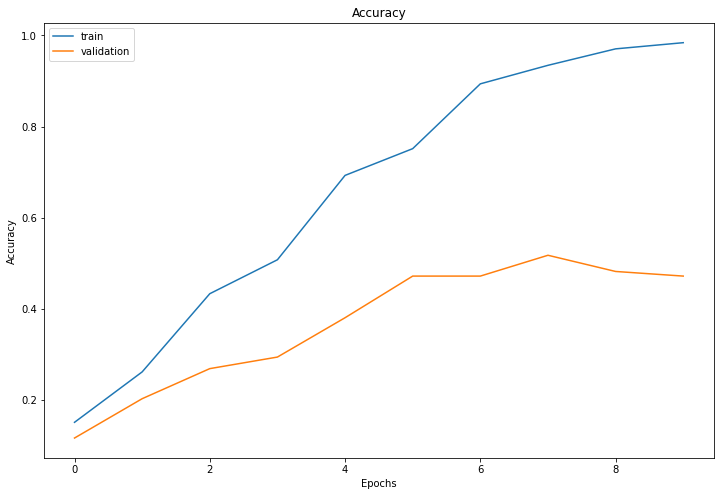

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(x=X_test_reshaped, y=y_test)
print("Test accuracy:\t{:.2f}".format(score[1]))

10/10 [==============================] - 1s 109ms/step - loss: 3.2082 - accuracy: 0.5724
Test accuracy:	0.57


Normalized confusion matrix


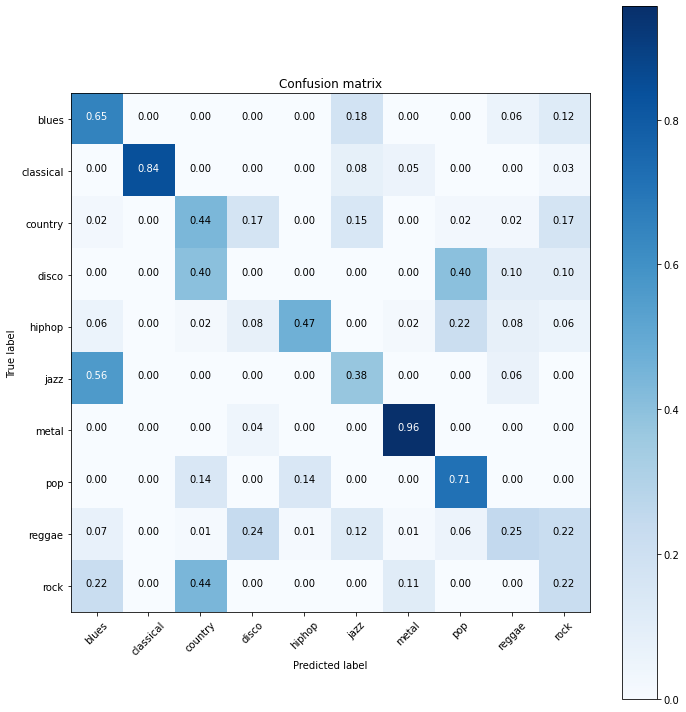

In [ ]:
y_pred = model.predict(X_test_reshaped)
cm = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))

keys = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

Better results but again lots of overfitting, probably due to the model complexity (+30*10e6 parameters) facing the few data samples. We confirm that transfer learning from weights trained on natural images is feasible with synthetic data.

Interestingly enough, this model consistently mistakes reggae for disco which were the two adversarial examples in our recommender system.

# Conclusions
In this report we explored the GTZAN dataset, learned about it's flaws and try to overcome them. We built a simple recommender system that also helped us identify replicas in the dataset. We built and trained different classifiers and evaluated their performance. We tried to combat the several errors that happened such as overfitting (it is worth mentioning that we tried techniques that are not displayed in this notebook as they didn't yield good results such as data augmentation or learning rate schedulers) and finally we evaluated the results and tried to provide meaningful explanations. Finally, our not so good results in comparison with other benchmarks may be excused by using a corrected "fair" train/test partition.

Probably the biggest takeway is that, when working with few data samples, deep neural networks struggle generalizing and instead become horses[1]. Even the most complex CNN model we trained (VGG16) barely beat a simple FFNN trained with musically coherent features, that is because our CNNs were trained with no given musical knowledge in the architectures nor in the data samples.

#References
[[1] Sturm, B.L. (2013). A simple method to determine if a music
information retrieval system is a horse.](https://vbn.aau.dk/en/publications/a-simple-method-to-determine-if-a-music-information-retrieval-sys)

[[2] Sturm, B.L. (2013). The GTZAN dataset: Its contents, its faults, their effects on evaluation, and its future use](https://arxiv.org/abs/1306.1461)

[[3] Aaron van den Oord et Al (2013). Deep content based music recommendation](https://papers.nips.cc/paper/5004-deep-content-based-music-recommendation.pdf)

[[4] Edward Ma (2019). Data Augmentation for Audio](https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6)

[[5] Stefan Hinterstoisser et al. (2018). On Pre-Trained Image Features and Synthetic Images
for Deep Learning](https://openaccess.thecvf.com/content_ECCVW_2018/papers/11129/Hinterstoisser_On_Pre-Trained_Image_Features_and_Synthetic_Images_for_Deep_Learning_ECCVW_2018_paper.pdf)